In [88]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [14]:
mnist = keras.datasets.mnist.load_data()

In [15]:
(X_train_full, y_train_full) , (X_test, y_test)  = mnist

In [16]:
X_train_full, X_test= X_train_full.reshape(X_train_full.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

In [17]:
X_train_full = MinMaxScaler().fit_transform(X_train_full)
X_test = MinMaxScaler().fit_transform(X_test)

In [18]:
X_train, y_train, X_valid, y_valid = X_train_full[:50000], y_train_full[:50000], X_train_full[50000:], y_train_full[50000:]

In [19]:
def build_classifier(input_shape=[784], 
                     n_neurons_hidden=30,
                     n_hidden=2, 
                     activation_hidden='relu',
                     n_neurons_output=10,
                     activation_output='softmax', 
                     lr=1e-3,
                    loss='sparse_categorical_crossentropy',
                    metrics='accuracy'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for k in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons_hidden, activation=activation_hidden))
    model.add(keras.layers.Dense(n_neurons_output, activation=activation_output))
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [28]:
model = build_classifier()

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                23550     
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
Total params: 24,790
Trainable params: 24,790
Non-trainable params: 0
_________________________________________________________________


# Base estimation - Early Stopping

In [53]:
early_callback = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
         epochs=20, callbacks=[early_callback])

Epoch 1/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1088 - accuracy: 0.9693 - val_loss: 0.1333 - val_accuracy: 0.9613
Epoch 2/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1084 - accuracy: 0.9696 - val_loss: 0.1325 - val_accuracy: 0.9625
Epoch 3/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1081 - accuracy: 0.9697 - val_loss: 0.1317 - val_accuracy: 0.9625
Epoch 4/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1076 - accuracy: 0.9697 - val_loss: 0.1331 - val_accuracy: 0.9625
Epoch 5/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1073 - accuracy: 0.9701 - val_loss: 0.1315 - val_accuracy: 0.9628
Epoch 6/20
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1069 - accuracy: 0.9697 - val_loss: 0.1316 - val_accuracy: 0.9624
Epoch 7/20
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1065 - accuracy: 0.9699 - val_loss: 0.1310 - val_accuracy:

<AxesSubplot:>

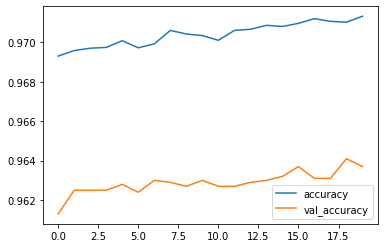

In [54]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [55]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.1361 - accuracy: 0.9600


[0.13614419102668762, 0.9599999785423279]

In [56]:
model.predict(X_test[:20]).argmax(axis=1), y_test[:20]

1/1 [==============================] - 0s 20ms/step


(array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
       dtype=int64),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
       dtype=uint8))

In [92]:
class OptimalLearningRate(keras.callbacks.Callback):
    def __init__(self, n_iters = 100, l0=1e-5, lf=10):
        self.learning = []
        self.loss = []
        self.accuracy = []
        self.iter = 0
        self.n_iters = n_iters
        self.l0 = l0
        self.lf = lf
    def on_batch_end(self, batch,logs=None):
        self.loss.append(logs['loss'])
        self.accuracy.append(logs['accuracy'])
        curr_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning.append(curr_rate)
        self.iter += 1
        rate = np.exp(np.log(self.lf/self.l0)/self.n_iters)
        keras.backend.set_value(self.model.optimizer.learning_rate, curr_rate*rate)
        if self.iter == self.n_iters:
            self.model.stop_training = True        

# Finding best Learning Rate

In [102]:
keras.backend.clear_session()
model2 = build_classifier(lr=1e-5)
lr_callback = OptimalLearningRate(n_iters=1000)
history = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid),
         epochs=20, callbacks=[lr_callback])

Epoch 1/20
1563/1563 [==============================] - 3s 2ms/step - loss: 1.9616 - accuracy: 0.3145 - val_loss: 2.4058 - val_accuracy: 0.1009


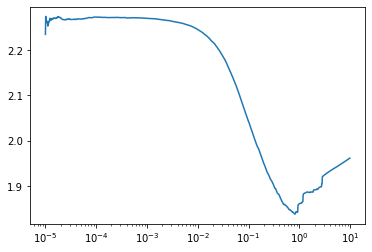

In [103]:
plt.xscale('log')
plt.plot(lr_callback.learning, lr_callback.loss)

**Learning rate of change**

In [110]:
idx = np.argmin(lr_callback.loss)
lr_change = lr_callback.learning[idx]

**Usually the optimal learning rate is 10 times smaller than the learning rate of change**

In [111]:
ideal_lr = lr_change/10

In [112]:
ideal_lr

0.0820351481437683

### Training the model with the optimal learning rate found

In [116]:
keras.backend.clear_session()
op_model = build_classifier(lr=ideal_lr)
early_callback = keras.callbacks.EarlyStopping(patience=20)
history = op_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
         epochs=100, callbacks=[early_callback])

Epoch 1/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3768 - accuracy: 0.8863 - val_loss: 0.1981 - val_accuracy: 0.9428
Epoch 2/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1922 - accuracy: 0.9424 - val_loss: 0.1975 - val_accuracy: 0.9398
Epoch 3/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1486 - accuracy: 0.9555 - val_loss: 0.1498 - val_accuracy: 0.9544
Epoch 4/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1242 - accuracy: 0.9622 - val_loss: 0.1386 - val_accuracy: 0.9569
Epoch 5/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1090 - accuracy: 0.9669 - val_loss: 0.1193 - val_accuracy: 0.9664
Epoch 6/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0991 - accuracy: 0.9695 - val_loss: 0.1162 - val_accuracy: 0.9674
Epoch 7/100
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0888 - accuracy: 0.9724 - val_loss: 0.1371 - val_ac

In [117]:
op_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1769 - accuracy: 0.9662


[0.17694848775863647, 0.9661999940872192]

# Trying model with higher number of neurons

In [133]:
keras.backend.clear_session()
model3 = build_classifier(n_neurons_hidden=300, lr=1e-5)
lr_callback = OptimalLearningRate(n_iters=1000)
history = model3.fit(X_train, y_train, validation_data=(X_valid, y_valid),
         epochs=20, callbacks=[lr_callback])

Epoch 1/20
1563/1563 [==============================] - 4s 3ms/step - loss: nan - accuracy: 0.3277 - val_loss: nan - val_accuracy: 0.0991


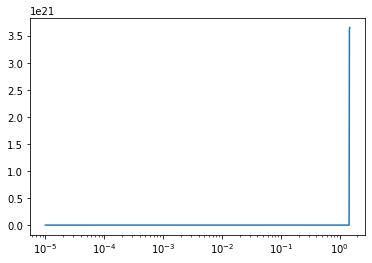

In [134]:
plt.xscale('log')
plt.plot(lr_callback.learning, lr_callback.loss)

In [135]:
idx = np.argmin(lr_callback.loss)
lr_change = lr_callback.learning[idx]
ideal_lr = lr_change/10
ideal_lr

0.15275659561157226

In [136]:
keras.backend.clear_session()
op_model = build_classifier(n_neurons_hidden=300, lr=ideal_lr)
early_callback = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = op_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
         epochs=100, callbacks=[early_callback])

Epoch 1/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2555 - accuracy: 0.9217 - val_loss: 0.1458 - val_accuracy: 0.9573
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1026 - accuracy: 0.9690 - val_loss: 0.0920 - val_accuracy: 0.9710
Epoch 3/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0661 - accuracy: 0.9792 - val_loss: 0.1187 - val_accuracy: 0.9619
Epoch 4/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0464 - accuracy: 0.9860 - val_loss: 0.0725 - val_accuracy: 0.9790
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0337 - accuracy: 0.9892 - val_loss: 0.0779 - val_accuracy: 0.9780
Epoch 6/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0878 - val_accuracy: 0.9759
Epoch 7/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.0723 - val_ac

In [144]:
op_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0634 - accuracy: 0.9833


[0.06343881040811539, 0.983299970626831]

**Over 98% accuracy, the goal!**

In [146]:
op_model.predict(X_test[:30]).argmax(axis=1), y_test[:30]

1/1 [==============================] - 0s 20ms/step


(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
        6, 5, 4, 0, 7, 4, 0, 1], dtype=int64),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
        6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8))

### Big neural network with non-optimal learning rate

Just to see what happens

In [139]:
keras.backend.clear_session()
nop_model = build_classifier(n_neurons_hidden=300, lr=1e-3)
nearly_callback = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
history = nop_model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
         epochs=100, callbacks=[nearly_callback])

Epoch 1/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8839 - accuracy: 0.5442 - val_loss: 1.3773 - val_accuracy: 0.7787
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0449 - accuracy: 0.8034 - val_loss: 0.7484 - val_accuracy: 0.8505
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6724 - accuracy: 0.8486 - val_loss: 0.5376 - val_accuracy: 0.8801
Epoch 4/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.5325 - accuracy: 0.8685 - val_loss: 0.4476 - val_accuracy: 0.8884
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4626 - accuracy: 0.8800 - val_loss: 0.3976 - val_accuracy: 0.8973
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4200 - accuracy: 0.8879 - val_loss: 0.3666 - val_accuracy: 0.9025
Epoch 7/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3911 - accuracy: 0.8934 - val_loss: 0.3441 - val_ac

In [141]:
nop_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1189 - accuracy: 0.9649


[0.11889161169528961, 0.964900016784668]